In [17]:
import numpy as np
import brainpy as bp
import brainpy.math as bm

from scipy.sparse import csr_matrix
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [18]:
class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36., EL=-54.387, gL=0.03,
               V_th=20., C=1.0, **kwargs):
    # providing the group "size" information
    super(HH, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # initialize variables
    self.V = bm.Variable(bm.random.randn(self.num) - 70.)
    self.m = bm.Variable(0.5 * bm.ones(self.num))
    self.h = bm.Variable(0.6 * bm.ones(self.num))
    self.n = bm.Variable(0.32 * bm.ones(self.num))
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    # integral functions
    self.int_V = bp.odeint(f=self.dV, method='exp_auto')
    self.int_m = bp.odeint(f=self.dm, method='exp_auto')
    self.int_h = bp.odeint(f=self.dh, method='exp_auto')
    self.int_n = bp.odeint(f=self.dn, method='exp_auto')

  def dV(self, V, t, m, h, n, Iext):
    I_Na = (self.gNa * m ** 3.0 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4.0) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C
    return dVdt

  def dm(self, m, t, V):
    alpha = 0.1 * (V + 40) / (1 - bm.exp(-(V + 40) / 10))
    beta = 4.0 * bm.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m
    return dmdt
  
  def dh(self, h, t, V):
    alpha = 0.07 * bm.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bm.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h
    return dhdt

  def dn(self, n, t, V):
    alpha = 0.01 * (V + 55) / (1 - bm.exp(-(V + 55) / 10))
    beta = 0.125 * bm.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n
    return dndt

  def update(self, tdi, x=None):
    _t, _dt = tdi.t, tdi.dt
    # compute V, m, h, n
    V = self.int_V(self.V, _t, self.m, self.h, self.n, self.input, dt=_dt)
    self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
    self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
    self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)

    # update the spiking state and the last spiking time
    self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
    self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

    # update V
    self.V.value = V

    # reset the external input
    self.input[:] = 0.

In [19]:
class Body_Wall_muscle(bp.NeuGroup):
    def __init__(self, size, ECa= 60., gCa= 15.6, EK=-40., gK=34., EL=-24, gL=0.1,
                 V_th= 10., C= 22, p_max = 0.1, phi=1., phi_m = 1.2, gkr = 10., g_slo2 = 10. , g_Na = 0.01, ENa = 30, phi_n = 1.2, noise_factor = 0.01, **kwargs):
        # providing the group "size" information
        super(Body_Wall_muscle, self).__init__(size=size, **kwargs)

        # initialize parameters
        self.ECa = ECa
        self.EK = EK
        self.EL = EL
        self.ENa = ENa
        self.gCa = gCa
        self.g_Na   = g_Na
        self.gK = gK
        self.gL = gL
        self.C = C
        self.p_max = p_max
        self.V_th  = V_th
        self.noise =  noise_factor 
        self.phi_m  = phi_m
        self.phi_n  = phi_n
        self.alpha  = 43.
        self.beta   = 0.09
        self.g_slo2 = g_slo2
        self.gkr    = gkr
        self.phi    = phi

        # initialize variables
        self.V = bm.Variable(bm.random.randn(self.num) - 30.)
        self.m = bm.Variable(0.01 * bm.ones(self.num))
        self.h = bm.Variable(0.6 * bm.ones(self.num))
        self.n = bm.Variable(0.99 * bm.ones(self.num))
        self.p = bm.Variable(0.2 * bm.ones(self.num))
        self.kr = bm.Variable(0.0 * bm.ones(self.num))

        self.p_slo2 = bm.Variable(bm.zeros(self.num))
        self.Ca   = bm.Variable(bm.zeros(self.num))
        self.Ica  = bm.Variable(bm.zeros(self.num))

        self.input = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
        self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

        # integral functions
        self.int_V = bp.odeint(f=self.dV, method='exp_auto')
        self.int_m = bp.odeint(f=self.dm, method='exp_auto')
        self.int_h = bp.odeint(f=self.dh, method='exp_auto')
        self.int_n = bp.odeint(f=self.dn, method='exp_auto')
        self.int_p = bp.odeint(f=self.dp, method='exp_auto')
        self.int_p_slo2 = bp.odeint(f=self.dp_slo2, method='exp_auto')
        self.int_Ca = bp.odeint(f=self.dCa, method='exp_auto')
        self.int_kr = bp.odeint(f=self.dkr, method='exp_auto')

    def dV(self, V, t, m, h, n, p, p_slo2, kr, Iext):
        I_Ca = (self.gCa * m ** 2.0 * h) * (V - self.V_th - self.ECa)
        I_K = (self.gK * n ** 4.0) * (V - self.V_th - self.EK)
        I_M = (self.p_max * p) * (V - self.V_th - self.EK)
        I_slo2 = (self.g_slo2 * self.m_slo2inf(V)**3 * p_slo2) * (V -  self.EK)
        I_Na = self.g_Na * (V - self.V_th - self.ENa)
        I_kr = self.gkr *(1-kr) * self.krinf(V) *  (V - self.EK)
        I_leak = self.gL * (V - self.V_th  - self.EL)
        dVdt = (- I_Ca  - I_K - I_Na - I_slo2 - I_leak - I_kr - I_M + Iext) / self.C
        return dVdt
    
    krinf  = lambda self, V: 0.5 *(1+bm.tanh((V -  self.V_th + 42)/ 5.0))
    m_slo2inf = lambda self, V: 1/(1+bm.exp(-(V - (-33.4)) / 3.2))

    def dkr(self, kr, t, V):
        # krinf = 0.5 *(1+bm.tanh((V -  self.V_th + 42)/ 5.0))
        taumkr= 62
        dkrdt = (self.krinf(V)-kr)/taumkr
        return dkrdt

    def dp_slo2(self, p_slo2, t, Ca, V):
        C2 = self.alpha * bm.power(Ca, 2)
        C3 = C2 + self.beta
        return self.phi * (C2 / C3 - p_slo2) * C3

    def dCa(self, Ca, t, m, h, V):
        ICa = (self.gCa * m ** 2.0 * h) * (V - self.V_th - self.ECa)
        return -0.15 * ICa * 1e-4 - 0.075 * (Ca - 0.001)

    def dn(self, n, t, V):
        ninf = 0.5 * (bm.tanh((V - self.V_th +15.2)/36.22)+1)
        tau_n = 1.18+511.78/(1+bm.exp((V - self.V_th + 89.3)/21.92))
        dndt = self.phi_n * (ninf-n)/tau_n
        return dndt

    # def dm(self, m, t, V):
    #     tau_m = 61/(1+bm.exp((V - self.V_th + 81.2)/45.6)) + 22.39/(1+bm.exp(-(V - self.V_th -24.26)/22.26)) - 14.25 
    #     minf = -0.53/(1+bm.exp(-(V - self.V_th - 26)/6.4)) + 1.058/(1+bm.exp(-(V - self.V_th +8.75)/7.2655)) + 0.0095
    #     dmdt = self.phi_m * (minf-m)/tau_m
    #     return dmdt

    def dm(self, m, t, V):
        tau_m = 0.4 + .7 / (bm.exp(-(V + 5. - self.V_th) / 15.) +
                       bm.exp((V + 5. - self.V_th) / 15.))
        minf = 1. / (1 + bm.exp(-(V + 8. - self.V_th) / 8.6))
        dmdt = self.phi_m * (minf-m)/tau_m
        return dmdt

    def dh(self, h, t, V):
        # hinf = 0.435/(1+bm.exp((V  - self.V_th + 10.38)/0.5554)) + 64.045/(1+bm.exp(-(V  - self.V_th -171.5)/30.8)) + 0.1
        hinf   = 0.42 / (1. + bm.exp((V + 11. - self.V_th) / 2.)) + 0.28
        # hinf  = (1.43 / (1 + bm.exp(-(V - self.V_th + 15 - 14.9) / 12)) + 0.14) * (5.96 / (1 + bm.exp((V  - self.V_th  + 15 + 20.5) / 8.1)) + 0.6 - 0.32)
        tau_h = 24
        dhdt = (hinf-h)/tau_h
        return dhdt

    def dp(self, p, t, V):
        pinf = 1/(1+bm.exp(-(V- self.V_th +45)/10))
        tau_p = 4000/(3.38*bm.exp((V- self.V_th+45)/20)+bm.exp(-(V- self.V_th +45)/20))
        dpdt = (pinf-p)/tau_p
        return dpdt

    def update(self, tdi, x=None):
        _t, _dt = tdi.t, tdi.dt
        # compute V, m, h, n
        noise_add = self.noise * bm.random.randn(self.num) / bm.sqrt(_dt)
        V = self.int_V(self.V, _t, self.m, self.h, self.n, self.p, self.p_slo2, self.kr, self.input/0.75, dt=_dt)
        self.h.value = self.int_h(self.h, _t, self.V, dt=_dt)
        self.m.value = self.int_m(self.m, _t, self.V, dt=_dt)
        self.n.value = self.int_n(self.n, _t, self.V, dt=_dt)
        self.p.value = self.int_p(self.p, _t, self.V, dt=_dt)
        self.p_slo2.value = self.int_p_slo2(self.p_slo2, _t, self.Ca, self.V, dt=_dt)
        self.Ca.value = self.int_Ca(self.Ca, _t, self.m, self.h, self.V, dt=_dt)
        self.kr.value = self.int_kr(self.kr, _t, self.V, dt=_dt)
        self.Ica.value = (self.gCa * self.m ** 2.0 * self.h) * (self.V - self.V_th - self.ECa)

        # update the spiking state and the last spiking time
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        self.t_last_spike.value = bm.where(self.spike, _t, self.t_last_spike)

        # update V
        self.V.value = V

        # reset the external input
        self.input[:] = 0.

In [20]:
def generate_neuron_connection_matrix(n_neurons=10, group_size=5):
    n_groups = n_neurons // group_size
    
    # 创建组内的连接矩阵
    size = group_size
    # 创建一个对角线下移一位和上移一位的矩阵，非对角线元素为1
    off_diag = np.ones(size - 1)
    group_connection = np.diag(off_diag, k=-1) + np.diag(off_diag, k=1)
    
    # 创建块对角矩阵
    matrix = np.kron(np.eye(n_groups), group_connection)  
    return matrix

# 生成矩阵并打印
connection_matrix = generate_neuron_connection_matrix()
print(connection_matrix)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [44]:
small_size = 6
connection_matrix = generate_neuron_connection_matrix(n_neurons=small_size, group_size=small_size)
w = bm.array(connection_matrix)

class MuscleNet(bp.DynamicalSystemNS):
    def __init__(self , num = small_size, conn_matrix = w):
        super().__init__()
        self.N = Body_Wall_muscle(size=small_size)
        self.N2N = bp.synapses.GapJunction(pre = self.N, post = self.N, conn = bp.connect.All2All(), g_max = 15. * conn_matrix)
        
    def update(self):
        t = bp.share.load('t')
        dt = bp.share.load('dt')
        # self.N.input = bm.linspace(20, 0, 5)
        self.N()
        self.N2N() 

In [45]:
net = MuscleNet(num = small_size, conn_matrix = w)  
# inputs = np.ones(int(8000. / bm.get_dt())) * 20.
runner = bp.DSRunner(net, monitors=['N.spike','N.V'], inputs= ['N.input',bm.linspace(30, 0, small_size) ] )
runner.run(1600.)
# print(runner.mon['N.spike'])


Predict 16000 steps: : 100%|██████████| 16000/16000 [00:21<00:00, 754.71it/s] 


In [46]:
print(np.where(runner.mon['N.spike'] == True))

(array([ 7068,  7071,  7076,  7081,  7086,  7088,  8111,  8113,  8118,
        8122,  8126,  8128,  9111,  9113,  9117,  9121,  9125,  9127,
       10102, 10105, 10108, 10113, 10116, 10118, 11093, 11095, 11099,
       11103, 11107, 11109, 12084, 12087, 12090, 12095, 12098, 12100,
       13076, 13078, 13082, 13086, 13090, 13092, 14068, 14071, 14075,
       14079, 14082, 14084, 15061, 15063, 15067, 15071, 15075, 15077]), array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1,
       2, 3, 4, 5, 0, 1, 2, 3, 4, 5]))


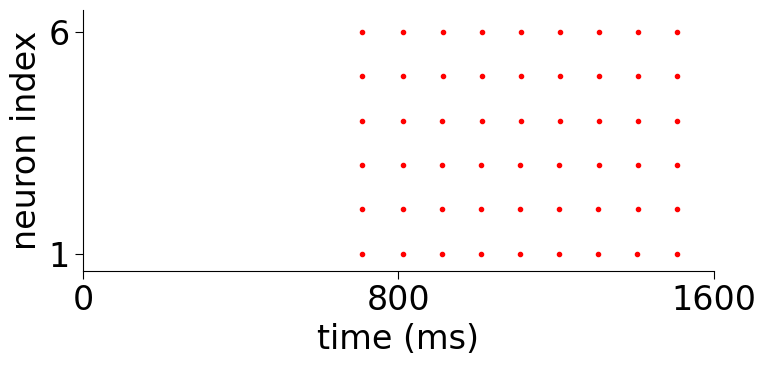

In [47]:
plt_style = {
    'figure.figsize' : (8, 4),
    'figure.autolayout' : True,
    'font.size' : 18,
    'lines.linewidth' : 3,
    'xtick.labelsize' : 24,
    'ytick.labelsize' : 24,
    'legend.fontsize' : 'small',
    'axes.spines.top' : False,
    'axes.spines.right' : False,
    'xtick.major.size' : 6,
    'ytick.major.size' : 6,
    'legend.fontsize' : 14,
    'axes.labelsize' : 24,
    'axes.titlesize' : 24,
    # 'font.family': "Times New Roman"
    }
for key, val in plt_style.items():
    plt.rcParams[key] = val

# bp.visualize.raster_plot(runner.mon['ts'],runner.mon['N.spike'], show=True) 


fig, ax = plt.subplots()
# bp.visualize.raster_plot(runner.mon['ts'], runner.mon['N.spike'], ax =ax, show=True)
marker = '.'
color  = 'r'
elements = np.where(runner.mon['N.spike'] > 0.)
index = elements[1] +1
time = runner.mon.ts[elements[0]]
plt.yticks([1, 6])
# plt.yticks(np.arange(1, small_size+1, 1))
plt.ylabel('neuron index')
plt.xlabel('time (ms)')
plt.xlim([0, 1600])
plt.ylim([0.6, 6.5])
plt.xticks(np.arange(0, 1601, 800))
plt.plot(time, index, marker+color, markersize=6)
plt.savefig('Figure/muscle_spikes.svg', dpi = 300)
# plt.xticks(np.arange(0, 2001, 1000))

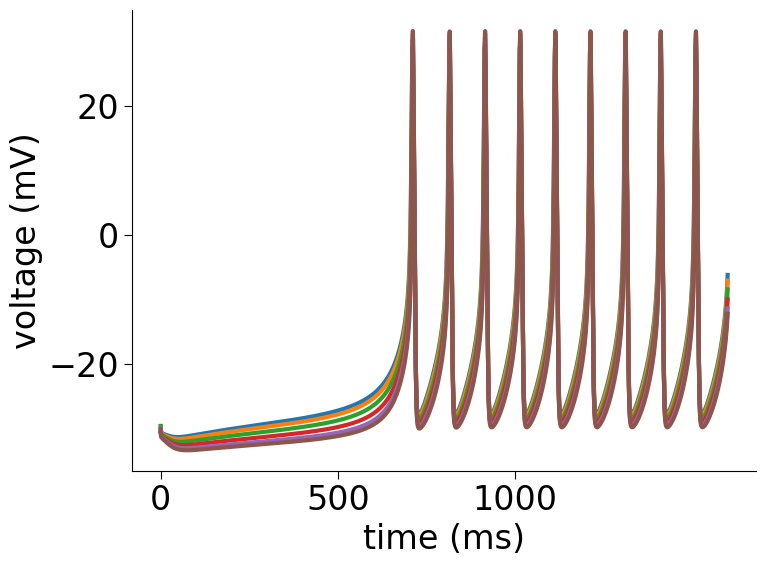

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(small_size):
    ax.plot(runner.mon['ts'], runner.mon['N.V'][:, i], label=f'V{i}')
ax.set_xlabel('time (ms)')
ax.set_ylabel('voltage (mV)')
ax.set_xticks(np.arange(0, 1001, 500))


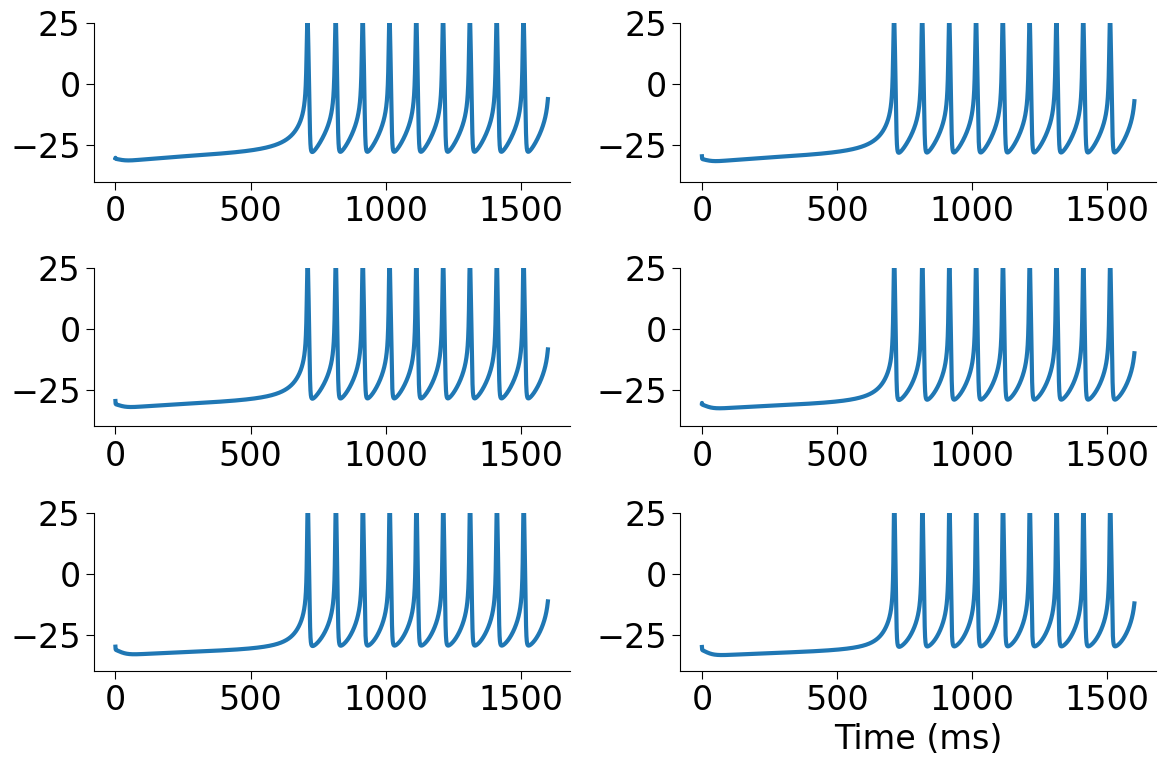

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()
# 遍历每个子图，绘制对应的数据
for idx in range(6):
    axes[idx].set_yticks(np.arange(-25, 26, 25))
    axes[idx].set_ylim(-40, 25)
    bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:, idx], ax=axes[idx], show=False)

    

# 调整子图布局
plt.tight_layout()

# 显示图像
plt.savefig('Figure/muscle_net_10.png')
plt.show()


In [50]:
# bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:,0], show=True)
# bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:,1], show=True)
# bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:,2], show=True)
# bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:,3], show=True)
# bp.visualize.line_plot(runner.mon.ts, runner.mon['N.V'][:,4], show=True)

In [51]:
print(runner.mon['N.V'].shape)

(16000, 6)
